# Transit data

## Lecture objectives

1. Show how to access and use transit data in GTFS format
2. Provide more practice in joins and plotting

The General Transit Feed Specification is a common format for sharing transit data on schedules, fares, and so on. Here we'll use the `partridge` library to parse GTFS data files.

I included the data for [Santa Monica Big Blue Bus](http://transitfeeds.com/p/city-of-santa-monica/260) in the git repository. For other agencies, see this [useful compilation](https://github.com/andredarcie/awesome-gtfs).

[The partridge documentation](https://github.com/remix/partridge) gives some useful examples and code snippets. 

First, it seems that we can find the busiest date.

In [1]:
import partridge as ptg
path = '../data/gtfs' # this is the subfolder within your GitHub repository

date, service_ids = ptg.read_busiest_date(path)

And then on this date, load the feed. Again, this code snippet is from the `partridge` docs.

In [3]:
view = {'trips.txt': {'service_id': service_ids}}

feed = ptg.load_geo_feed(path, view)

Now we have an object called feed. Let's explore it.


In [4]:
feed.

SyntaxError: invalid syntax (2348489071.py, line 1)

In [5]:
feed.routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,3554,6216179,1,Main St & Santa Monica Blvd/UCLA,NaN,3,http://bigbluebus.com/Routes-and-Schedules/Rou...,F8971D,000000
1,3555,6216179,2,Wilshire Blvd/UCLA,NaN,3,http://bigbluebus.com/Routes-and-Schedules/Rou...,552988,FFFFFF
2,3556,6216179,3,Lincoln Blvd/LAX,NaN,3,http://bigbluebus.com/Routes-and-Schedules/Rou...,D31245,FFFFFF
3,3558,6216179,5,Olympic Blvd,NaN,3,http://bigbluebus.com/Routes-and-Schedules/Rou...,66B360,000000
4,3560,6216179,7,Pico Blvd,NaN,3,http://bigbluebus.com/Routes-and-Schedules/Rou...,9397CB,000000


In [6]:
feed.stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,893044,25140.0,25140.0,1601,1,NaN,0,0,NaN,1
1,893044,25200.0,25200.0,1305,2,NaN,0,0,0.2202,1
2,893044,25264.0,25264.0,361,3,NaN,0,0,0.6844,0
3,893044,25310.0,25310.0,362,4,NaN,0,0,1.0164,0
4,893044,25338.0,25338.0,363,5,NaN,0,0,1.2240,0


In [7]:
feed.stops.head()

,stop_id,stop_code,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,geometry
0,3,1268,OCEAN NB & PICO FS,1900 OCEAN AVE & SEAVIEW TER,NaN,NaN,NaN,NaN,NaN,0,POINT (-118.49093 34.00809)
1,4,1020,4TH NB & SANTA MONICA NS,1400 4TH ST & SANTA MONICA BLVD,NaN,NaN,NaN,NaN,NaN,0,POINT (-118.49507 34.01639)
2,5,1413,SANTA MONICA EB & 6TH NS,600 SANTA MONICA BLVD & 6TH ST,NaN,NaN,NaN,NaN,NaN,0,POINT (-118.49333 34.01788)
3,6,2001,SANTA MONICA EB & CENTINELA FS,12400 SANTA MONICA BLVD & CENTINELA AVE,NaN,NaN,NaN,NaN,NaN,0,POINT (-118.46751 34.03863)
4,7,2002,SAWTELLE SB & SANTA MONICA NS,1600 SAWTELLE BLVD & SANTA MONICA BLVD,NaN,NaN,NaN,NaN,NaN,0,POINT (-118.44849 34.04652)


The stops has a `geometry` column. Is this a `GeoDataFrame`?

In [8]:
type(feed.stops)

geopandas.geodataframe.GeoDataFrame

Yes! So we can map it.

<Axes: >

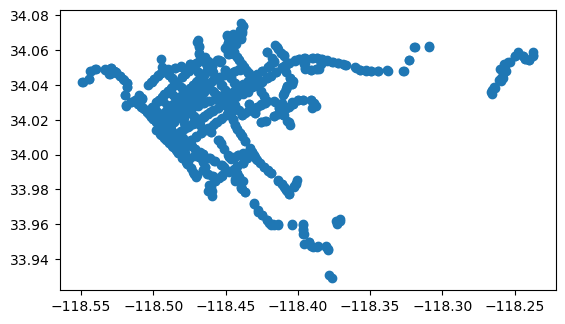

In [9]:
feed.stops.plot()

Let's compute and map a simple measure of transit accessibility (number of trips per day) at the stop level.

<div class="alert alert-block alert-info">
<strong>Thought exercise:</strong> How might you go about this?
</div>

We want a count of the number of trips at each stop. We saw above that `stop_times` had the stop id. So let's do the following:
* Aggregate `stop_times` by `stop_id` to generate counts
* Join this to the stops data (which has the geometry)
* Map the results

In [10]:
freqs = feed.stop_times.groupby('stop_id').size()
freqs

stop_id
1001    26
1002    26
1017     1
1021    44
1023    44
        ..
994     38
995     38
996     38
997     38
998     38
Length: 905, dtype: int64

In [11]:
# join on the index
freqs.name = 'n_trips'
stops = feed.stops.set_index('stop_id').join(freqs)
stops.head()

,stop_code,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,geometry,n_trips
stop_id,,,,,,,,,,,
3,1268,OCEAN NB & PICO FS,1900 OCEAN AVE & SEAVIEW TER,NaN,NaN,NaN,NaN,NaN,0,POINT (-118.49093 34.00809),35
4,1020,4TH NB & SANTA MONICA NS,1400 4TH ST & SANTA MONICA BLVD,NaN,NaN,NaN,NaN,NaN,0,POINT (-118.49507 34.01639),153
5,1413,SANTA MONICA EB & 6TH NS,600 SANTA MONICA BLVD & 6TH ST,NaN,NaN,NaN,NaN,NaN,0,POINT (-118.49333 34.01788),280
6,2001,SANTA MONICA EB & CENTINELA FS,12400 SANTA MONICA BLVD & CENTINELA AVE,NaN,NaN,NaN,NaN,NaN,0,POINT (-118.46751 34.03863),93
7,2002,SAWTELLE SB & SANTA MONICA NS,1600 SAWTELLE BLVD & SANTA MONICA BLVD,NaN,NaN,NaN,NaN,NaN,0,POINT (-118.44849 34.04652),43


[]

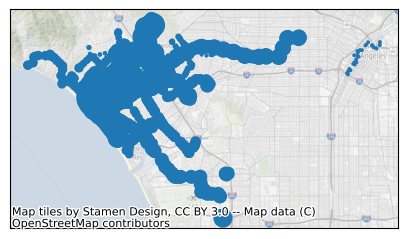

In [12]:
# map the results
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(5,5))
stops.to_crs('EPSG:3857').plot(markersize='n_trips', ax=ax)
ctx.add_basemap(ax, zoom=12, alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])

The markers are a little large. Let's create a new column with a scaled version of the marker size, and plot that instead.

[]

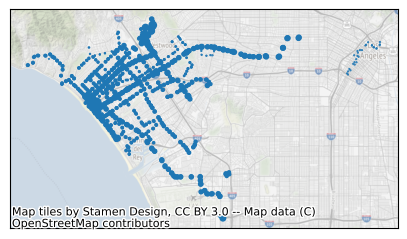

In [13]:
stops['n_trips_scaled']= stops.n_trips / 10

# same code as before, except for plotting n_trips_scaled instead of n_trips
fig, ax = plt.subplots(figsize=(5,5))
stops.to_crs('EPSG:3857').plot(markersize='n_trips_scaled', ax=ax)
ctx.add_basemap(ax, zoom=12, alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])

These accessibility measures are at the stop level, but you can imagine aggregating the combined frequencies to census tracts, and/or calculating the combined frequency within (say) 0.25 miles of a destination.

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>GTFS is the standard format for transit data</li>
  <li>GTFS is cumbersome to work with in raw form, but partridge makes it simpler</li>
</ul>
</div>